In [1]:
import glob, re, os
import numpy as np
import matplotlib.pyplot as plt
from typing import List
%run ../Task_4/cardiac_ml_tools.py

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Reading In The Data

In [3]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='../../cardiac_challenge/intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)

In [4]:
num_timesteps = 500

In [5]:
all_pECG_data = np.empty(shape=(len(file_pairs), num_timesteps, 12))
all_Vm_data = np.empty(shape=(len(file_pairs), num_timesteps, 75))
for index,(pecg, vm) in enumerate(file_pairs):
    print("pecg", pecg)
    print("vm", vm)
    all_Vm_data[index] = np.load(vm)
    all_pECG_data[index] = get_standard_leads(np.load(pecg))

pecg ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
vm ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
pecg ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v16.npy
vm ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v16.npy
pecg ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v2.npy
vm ../../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pat

# Normalizing The Data

In [6]:
# Getting the range of the data
print("Maximum value in the whole array:%d"%(all_pECG_data.max()))                    
print("Maximum value in the whole array:%d"%(all_pECG_data.min()))                    
print("Maximum value in the whole array:%d"%(all_Vm_data.max()))                    
print("Maximum value in the whole array:%d"%(all_Vm_data.min()))                    

Maximum value in the whole array:5
Maximum value in the whole array:-5
Maximum value in the whole array:49
Maximum value in the whole array:-93



We can see that 
* pECG Data is between -5 and 5
* Vm Data is between -93 and 49

In [7]:
# all_pECG_data = (all_pECG_data + 5) / 10
# all_Vm_data = (all_Vm_data + 100) / 150

# Splitting The Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(all_pECG_data, all_Vm_data, test_size = 0.20, random_state = 0)

# Defining The Model

In [9]:
from tensorflow.keras.layers import Conv1D, Input, Dense, Flatten, Lambda, Conv1DTranspose, Reshape
import tensorflow as tf
from tensorflow import keras

## Defining The Sampler

In [10]:
class DenseEncoder(keras.models.Model):
  def __init__(self):
    super(DenseEncoder, self).__init__()
    input_layer = keras.layers.Input(shape=(500,12))
    d1 = keras.layers.Dense(32, activation="relu")(input_layer)
    d2 = keras.layers.Dense(16, activation="relu")(d1)
    output_layer = keras.layers.Dense(8, activation="relu")(d2)

    self.encoder = keras.Model(input_layer, output_layer)

    
    x = keras.layers.Dense(16, activation="relu")(output_layer)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dense(75, activation="sigmoid")(x)
    self.decoder = keras.Model(output_layer, x)
    display(self.decoder.summary())

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = DenseEncoder()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.build((None, 500, 12))
display(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 8)]          0         
                                                                 
 dense_3 (Dense)             (None, 500, 16)           144       
                                                                 
 dense_4 (Dense)             (None, 500, 32)           544       
                                                                 
 dense_5 (Dense)             (None, 500, 75)           2475      
                                                                 
Total params: 3,163
Trainable params: 3,163
Non-trainable params: 0
_________________________________________________________________


None

Model: "dense_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 500, 8)            1080      
                                                                 
 model_1 (Functional)        (None, 500, 75)           3163      
                                                                 
Total params: 4,243
Trainable params: 4,243
Non-trainable params: 0
_________________________________________________________________


None

In [11]:
history = autoencoder.fit(x_train, y_train, 
          epochs=50, 
          batch_size=32,
          validation_data=(x_test, y_test),
          shuffle=True)

Epoch 1/50


2023-07-26 18:17:47.401652: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


403/403 [==============================] - 16s 37ms/step - loss: 42.4654 - val_loss: 42.4819
Epoch 2/50
403/403 [==============================] - 10s 25ms/step - loss: 42.4063 - val_loss: 42.4618
Epoch 3/50
403/403 [==============================] - 10s 24ms/step - loss: 42.3911 - val_loss: 42.4487
Epoch 4/50
403/403 [==============================] - 10s 23ms/step - loss: 42.3799 - val_loss: 42.4388
Epoch 5/50
403/403 [==============================] - 9s 22ms/step - loss: 42.3159 - val_loss: 42.3548
Epoch 6/50
403/403 [==============================] - 9s 23ms/step - loss: 42.2807 - val_loss: 42.3374
Epoch 7/50
403/403 [==============================] - 10s 24ms/step - loss: 42.2702 - val_loss: 42.3354
Epoch 8/50
403/403 [==============================] - 10s 25ms/step - loss: 42.2635 - val_loss: 42.3238
Epoch 9/50
403/403 [==============================] - 10s 24ms/step - loss: 42.2574 - val_loss: 42.3178
Epoch 10/50
403/403 [==============================] - 9s 23ms/step - loss: 4

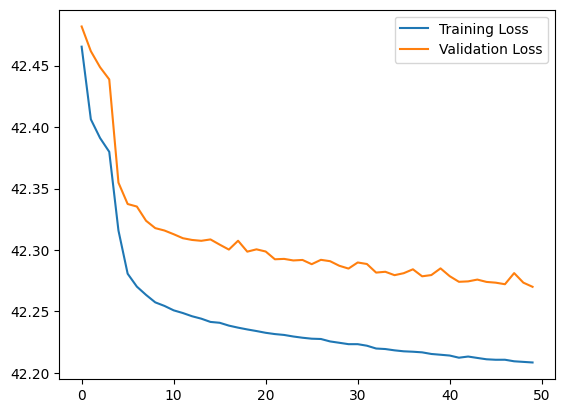

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

75


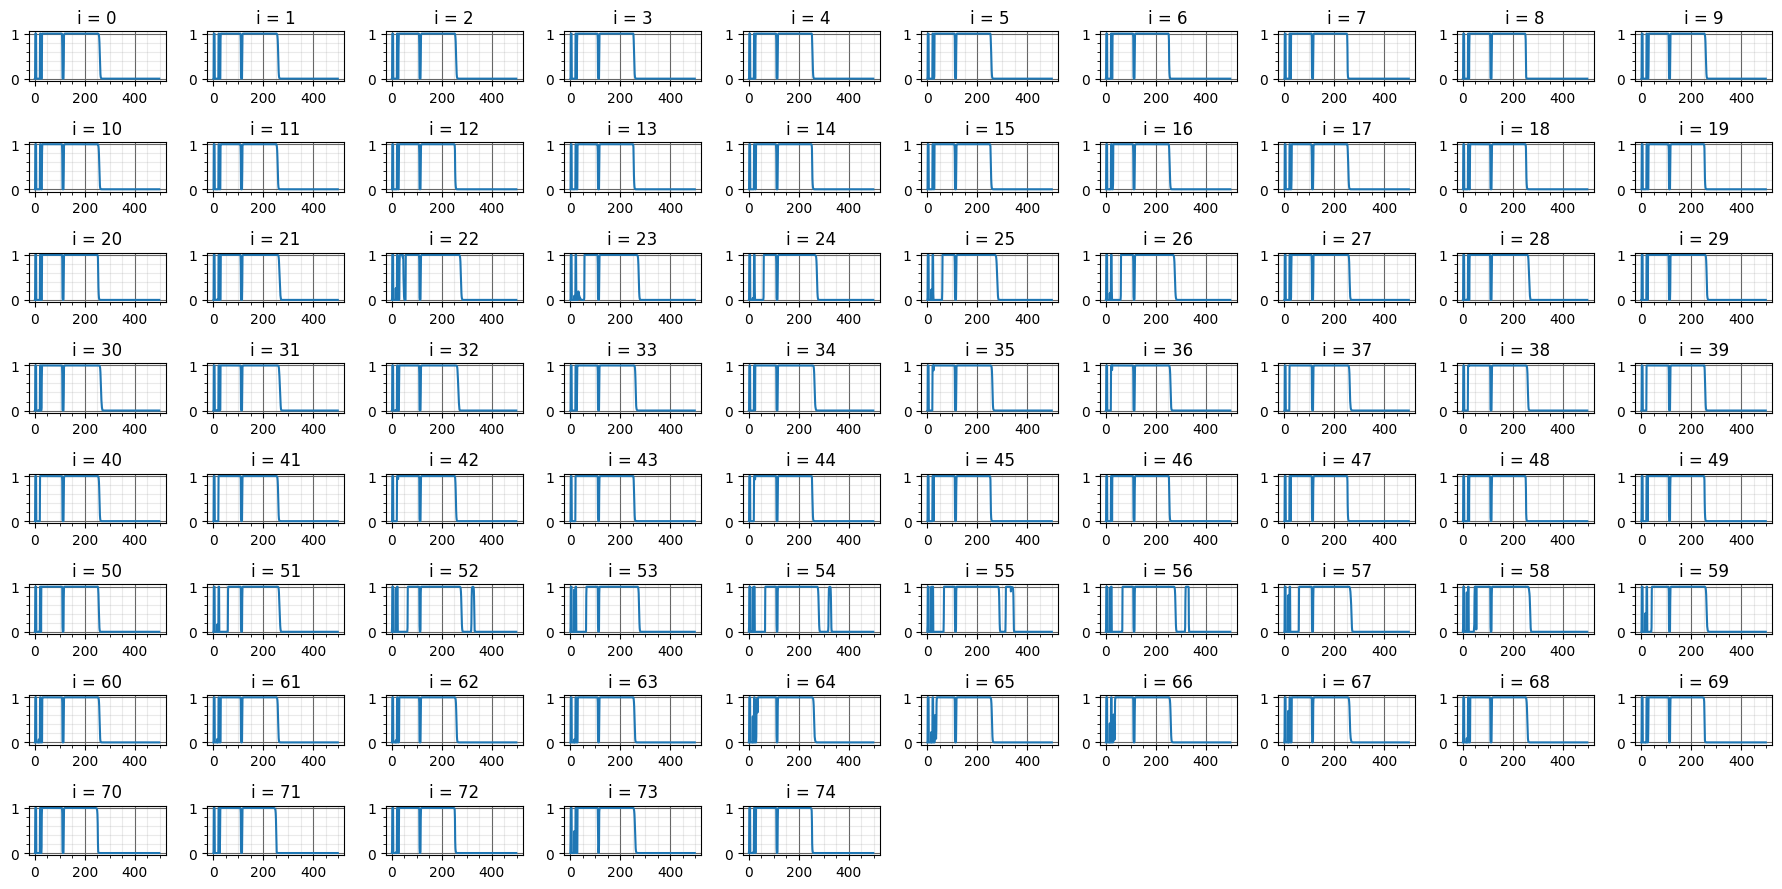

75


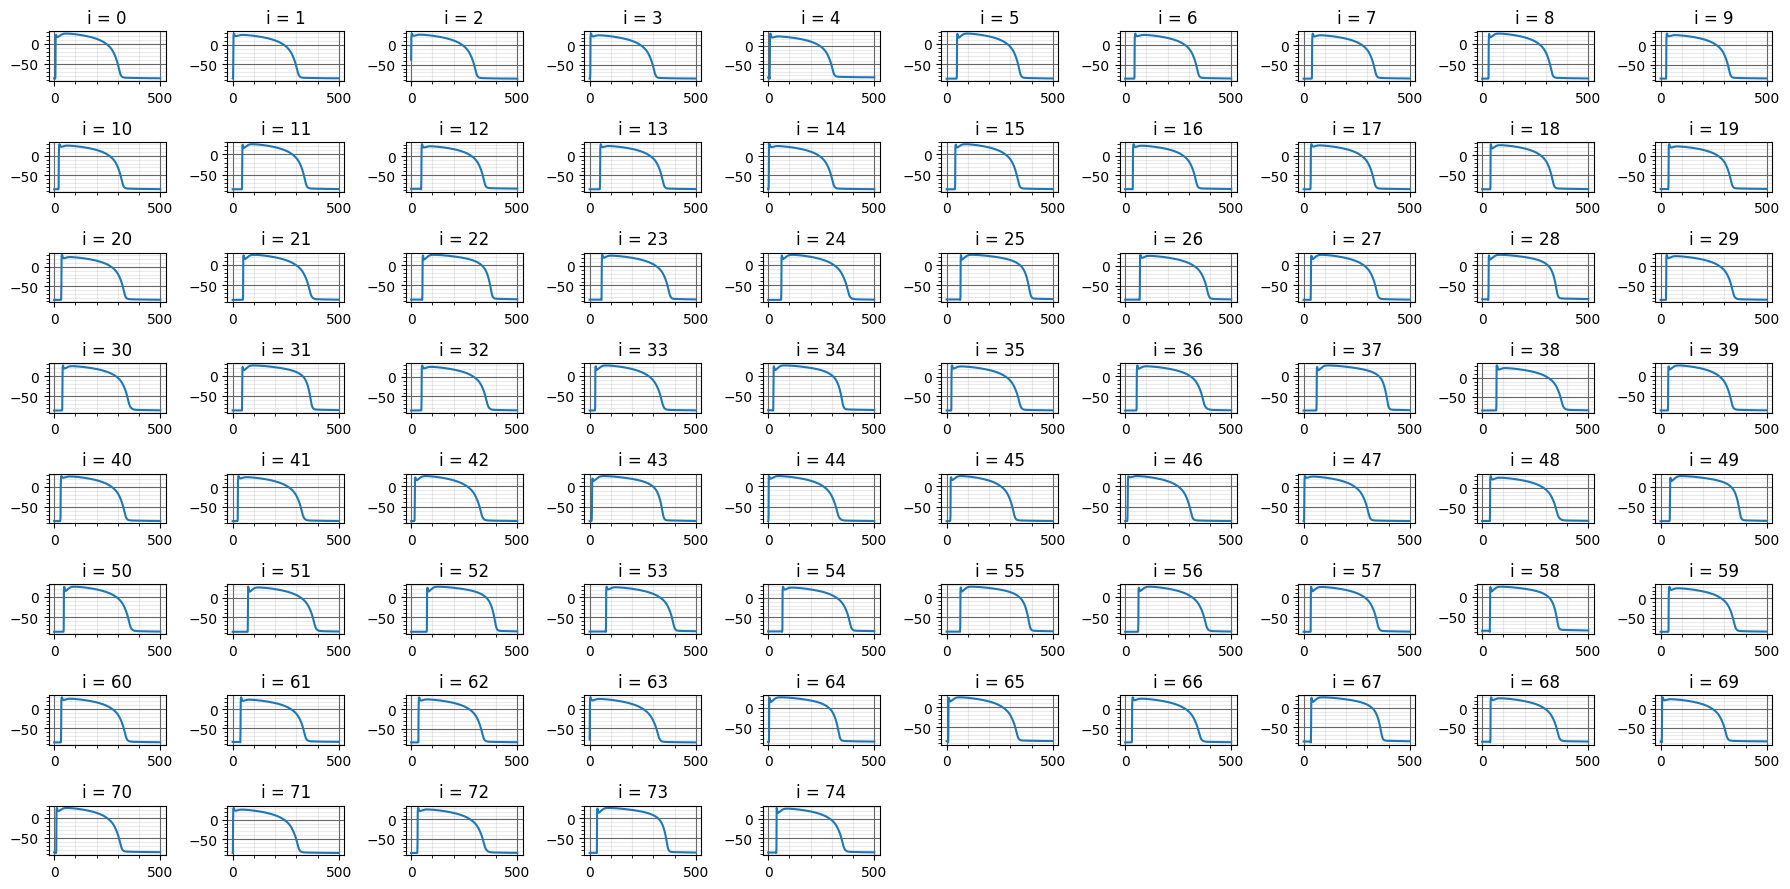

In [14]:
sample = 10
image = x_test[sample:sample+1]
encoded_imgs = autoencoder.encoder(image).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
VmData = decoded_imgs[0]
row = 7
column = 10
plt.figure(figsize=(18, 9))

print(VmData.shape[1])
for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

VmData = y_test[sample]
plt.figure(figsize=(18, 9))

print(VmData.shape[1])
for count, i in enumerate(range(VmData.shape[1])):
    plt.subplot(8, 10, count + 1)
    plt.plot(VmData[0:num_timesteps,i])
    plt.title(f'i = {i}')
    plt.grid(visible=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    # plt.xlabel('msec')
    # plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()